In [1]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os

In [14]:
# Set the image directory path with images you want to test
image_dir = r'C:\Users\matej.macek\OneDrive - Thermo Fisher Scientific\Desktop\Odevzdani\Data_Storage\Error_Measurements_Datasets\Contamination_Only_Dataset'

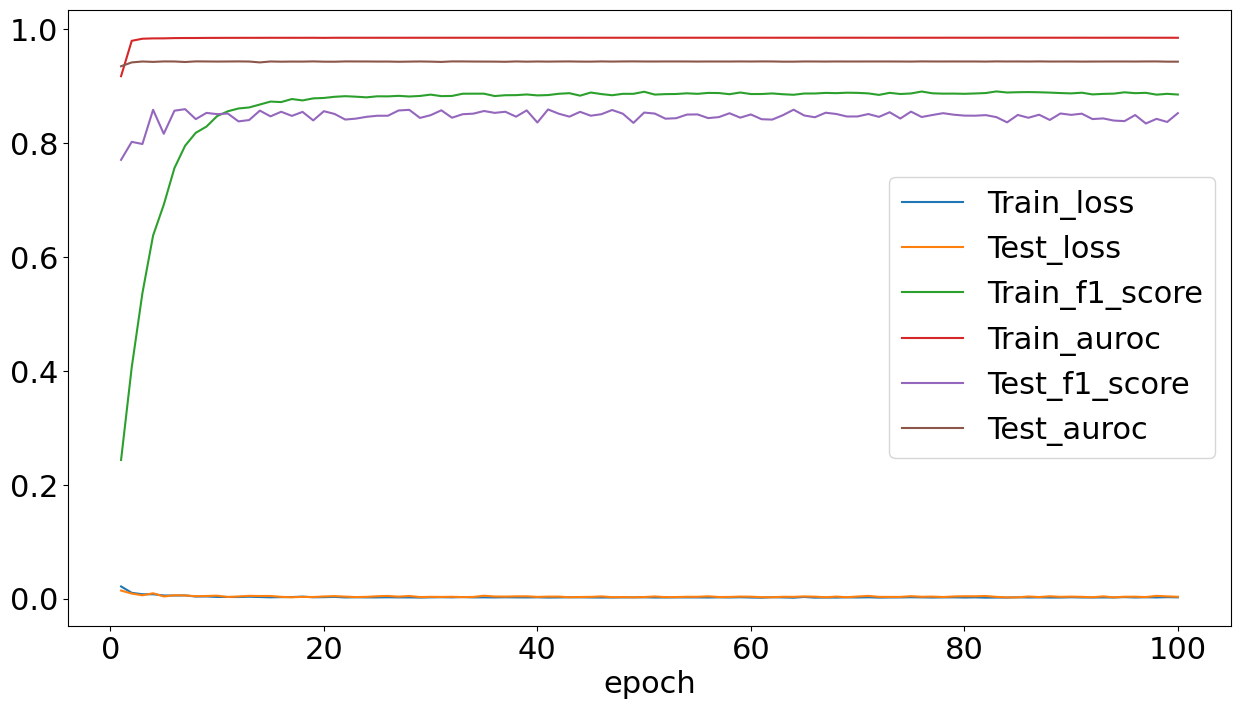

In [9]:
df = pd.read_csv('./TrainingResults/logWeightsContaminationOnly.csv')
plt.rcParams.update({'font.size': 22})
df.plot(x='epoch',figsize=(15,8));

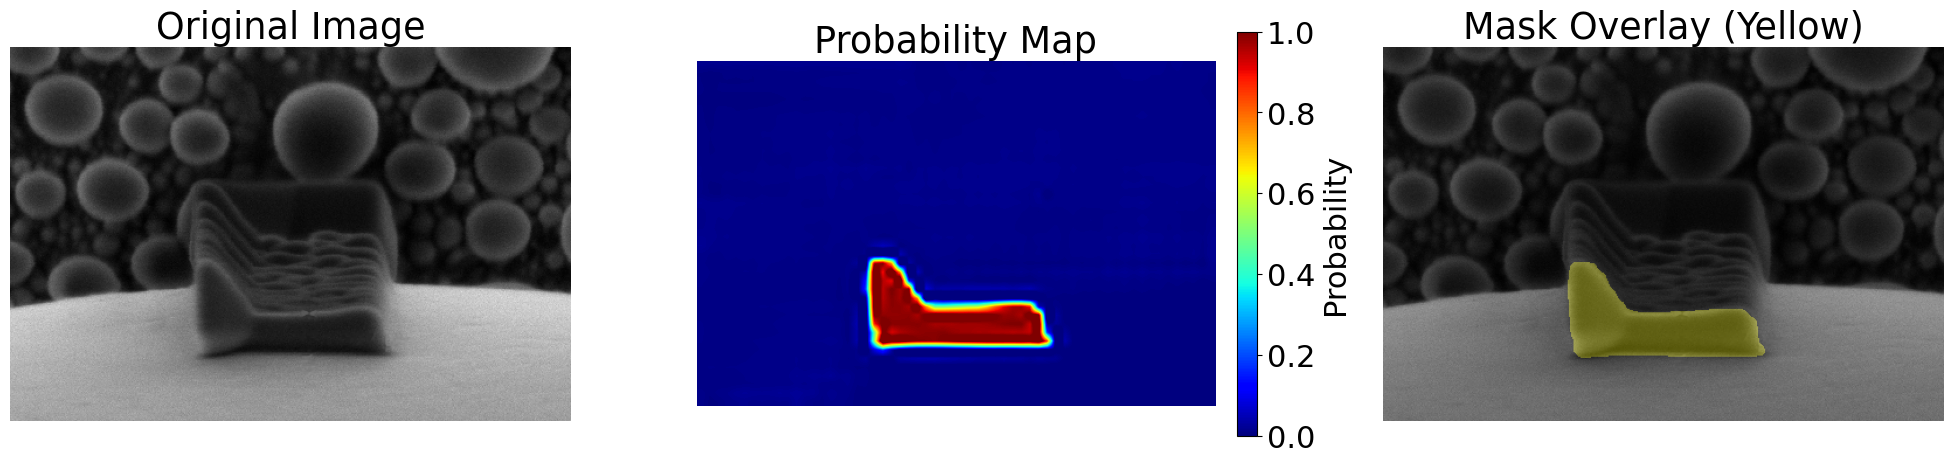

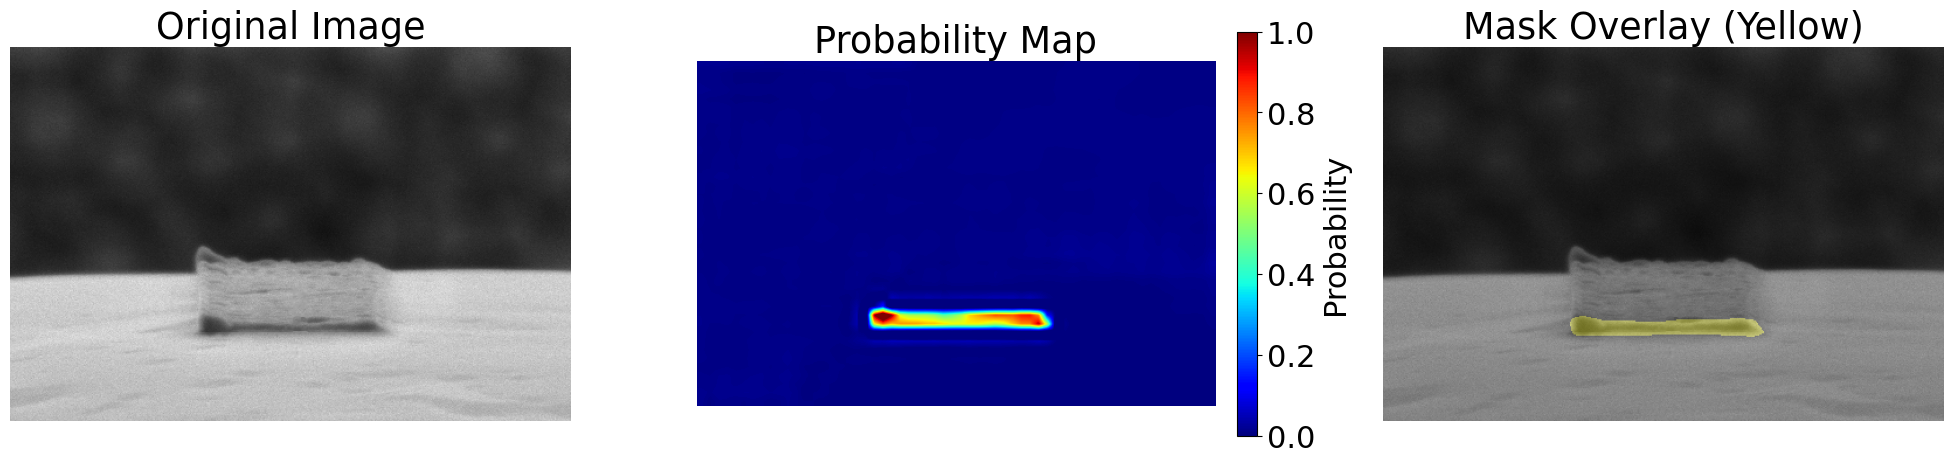

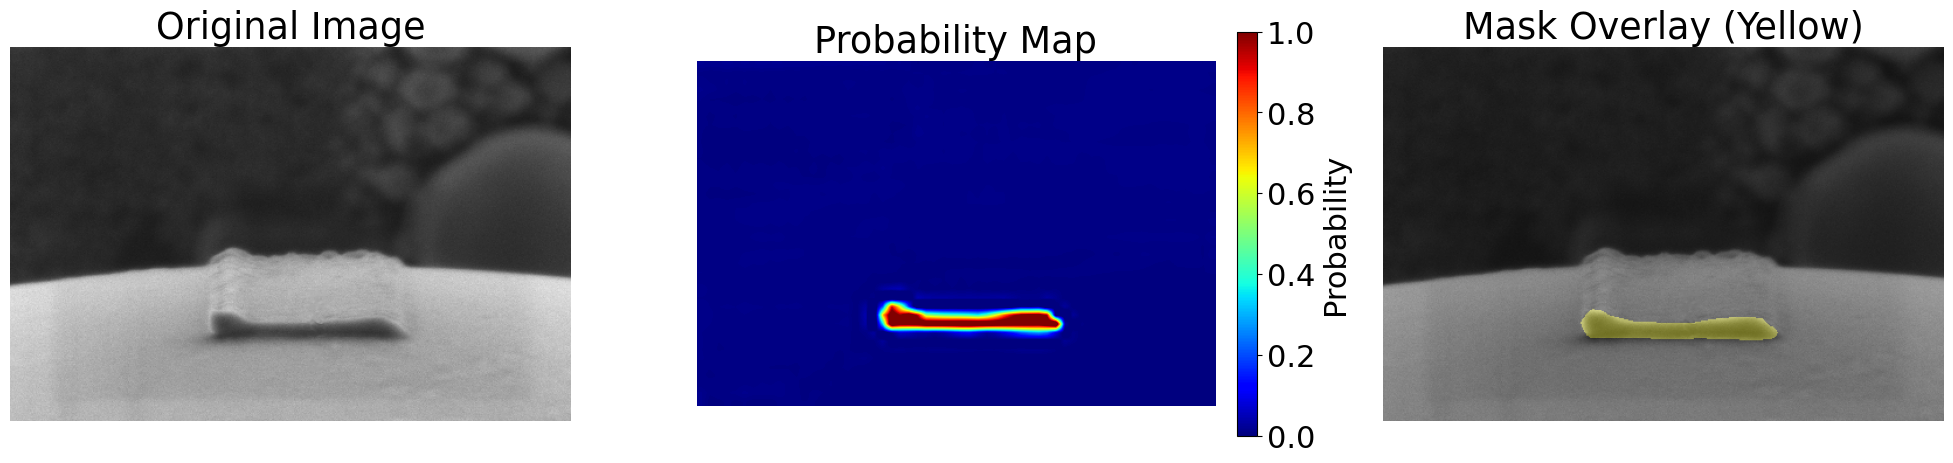

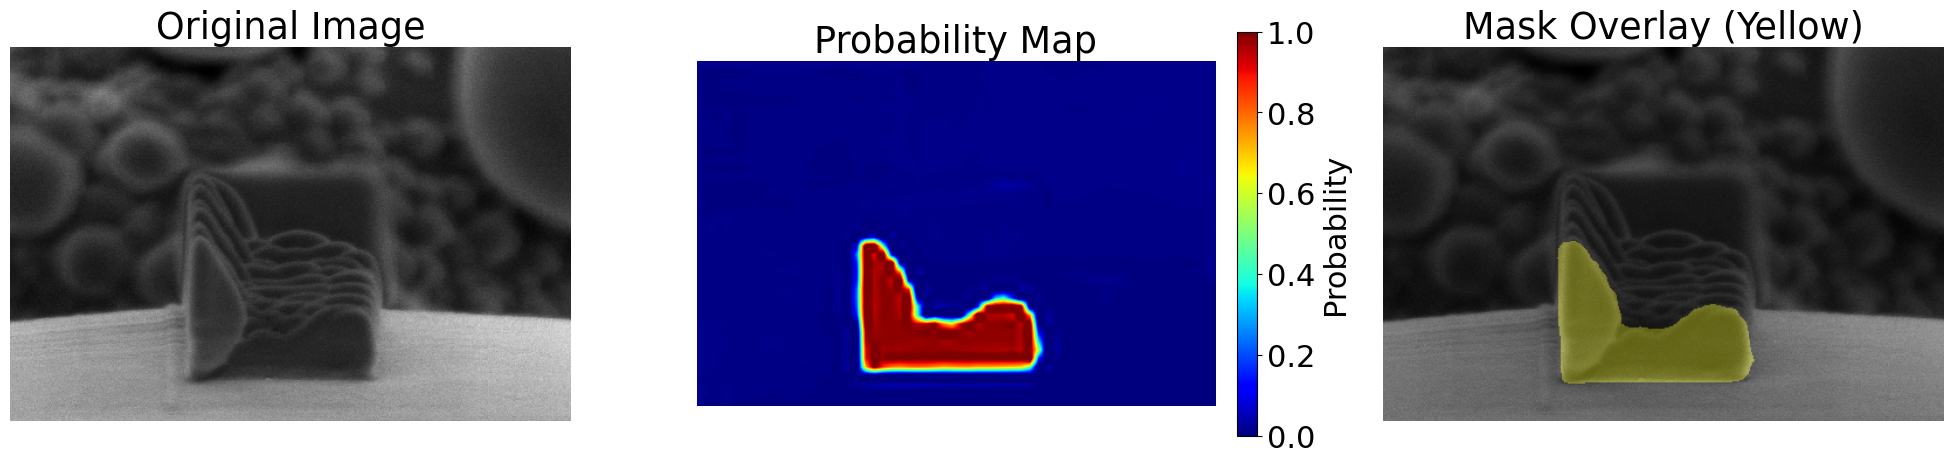

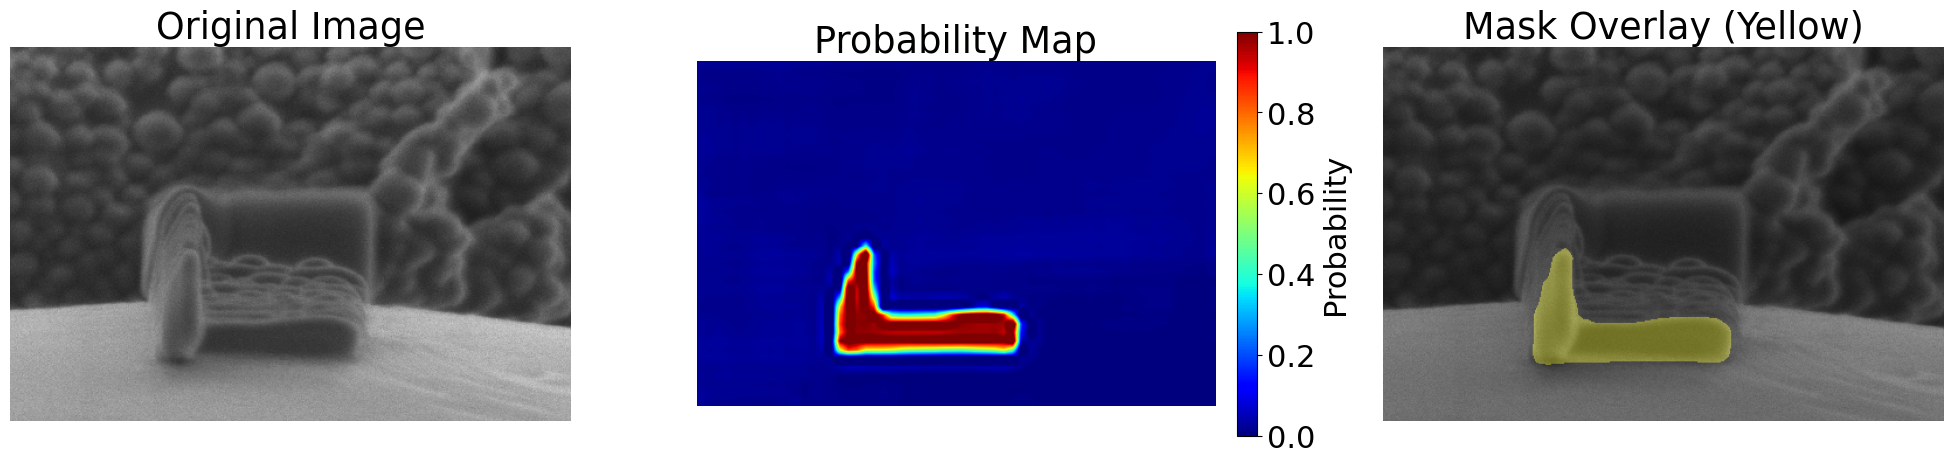

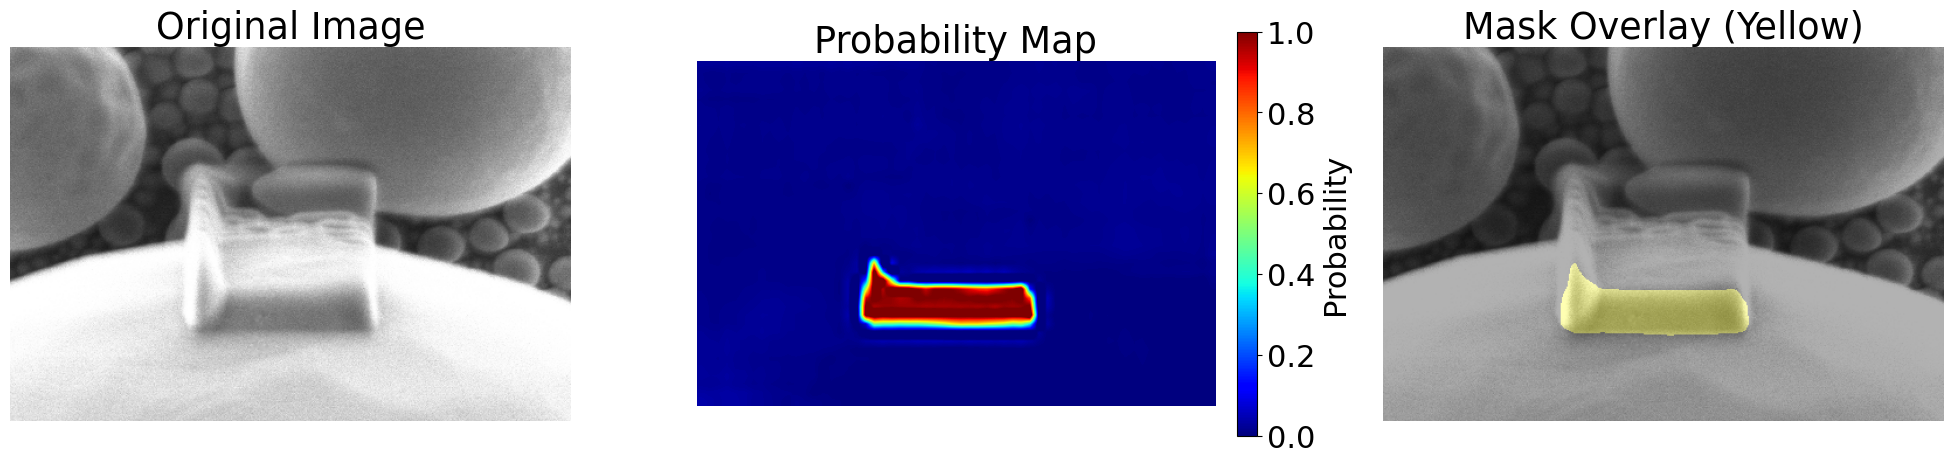

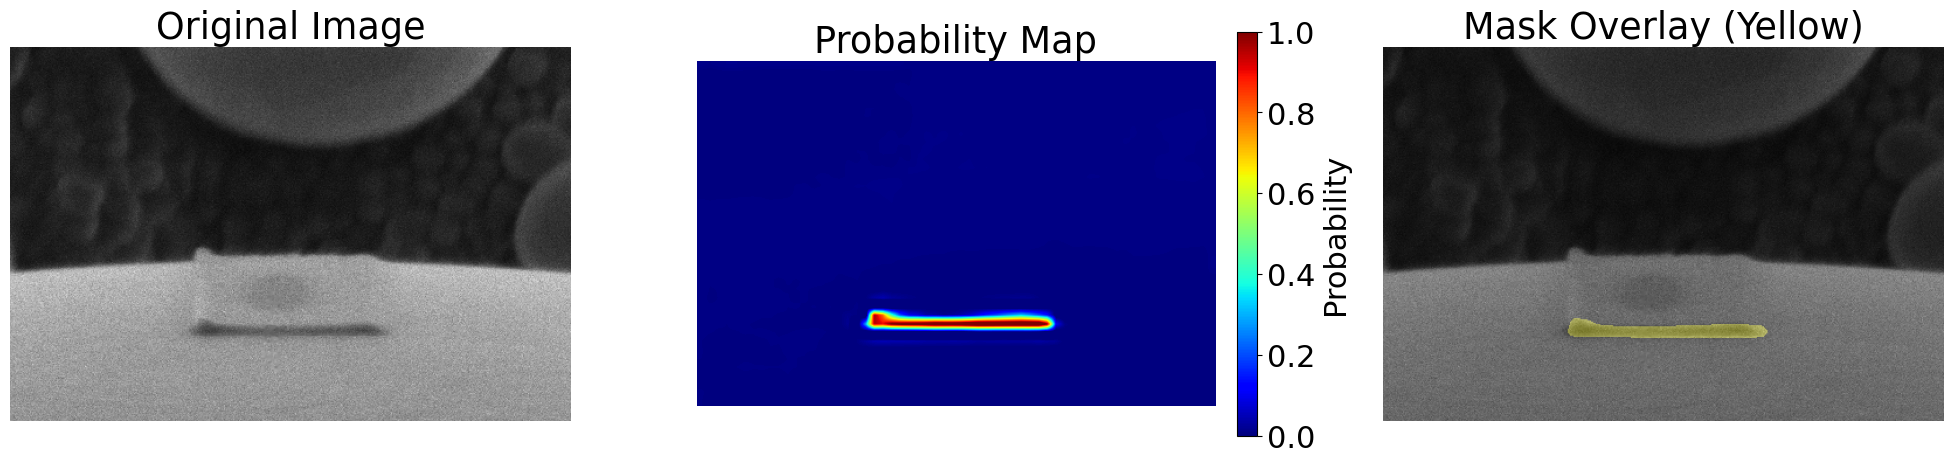

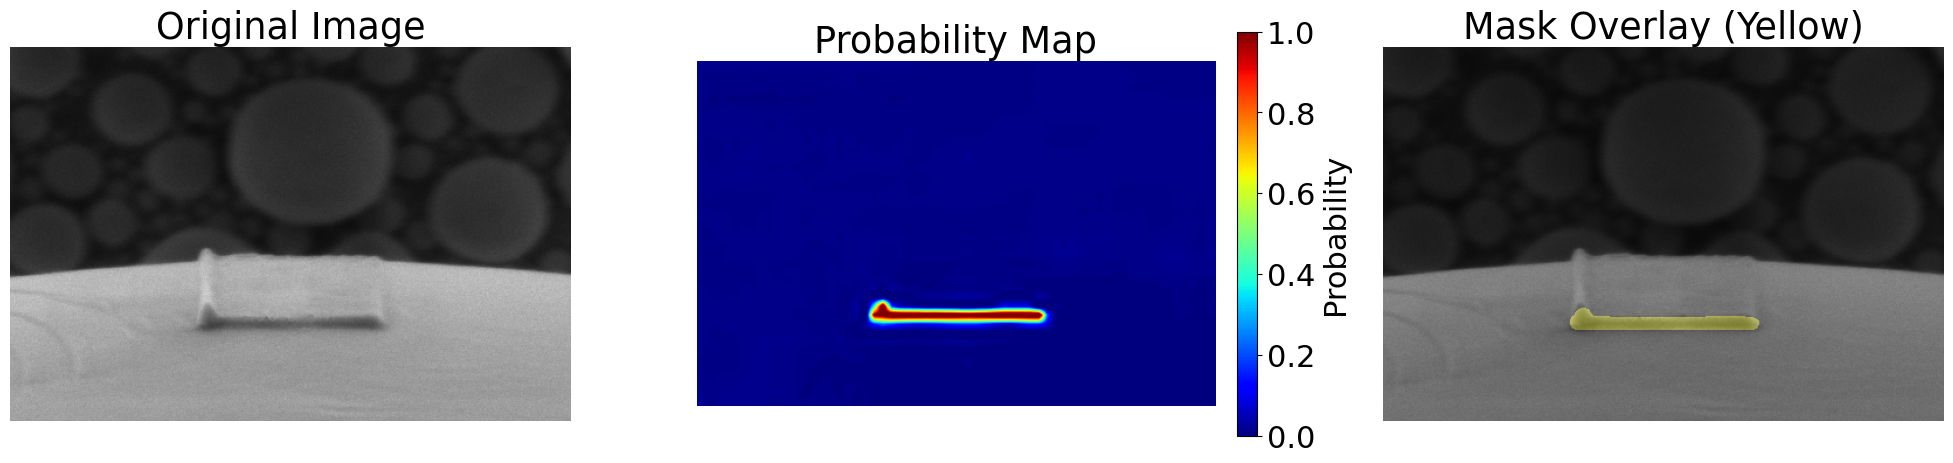

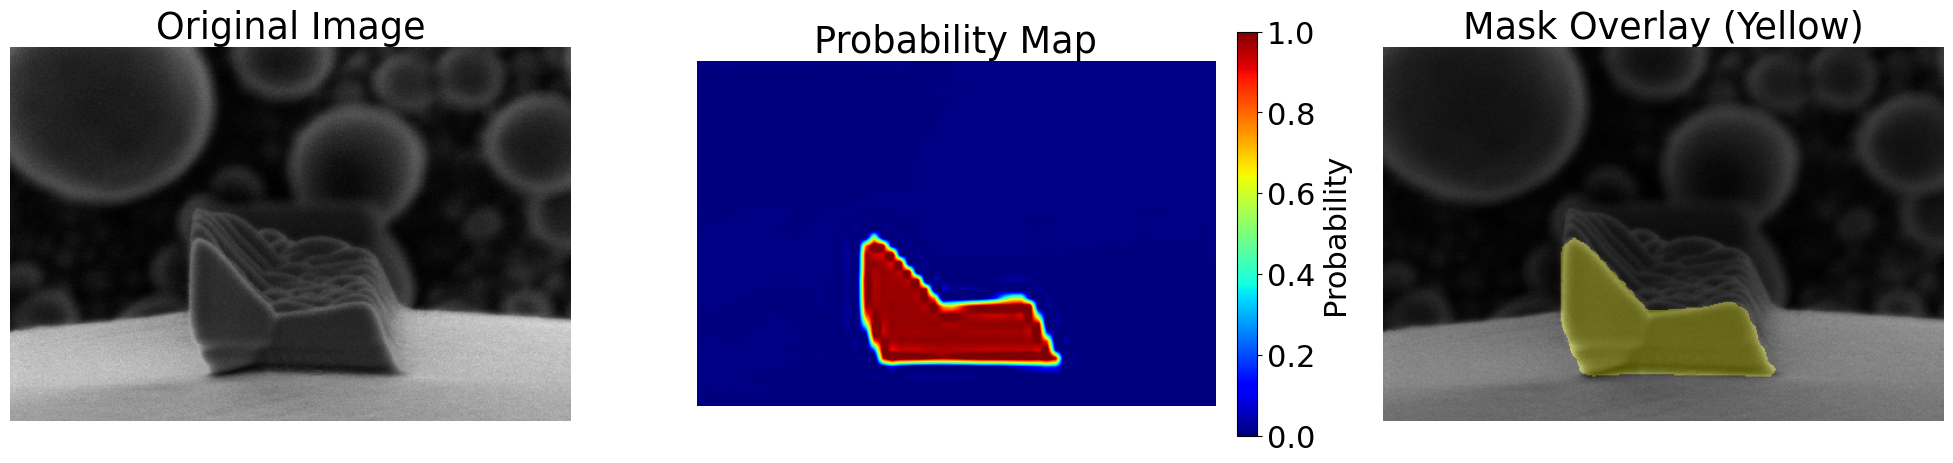

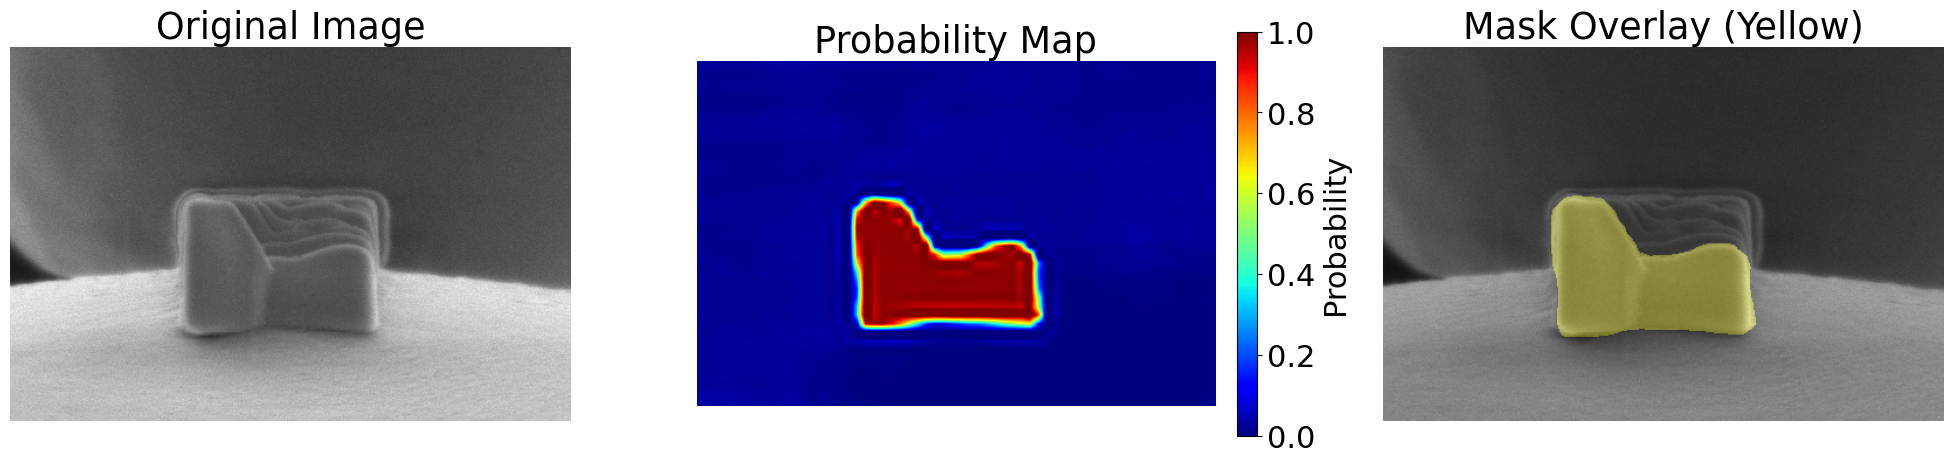

In [15]:

# Load the trained model and set it to evaluation mode
model = torch.load('./TrainingResults/weightsAugmented.pt')
model.eval()

i = 10  # Process a fixed number of images, for example

for filename in os.listdir(image_dir):
    if i == 0:
        break
    i -= 1

    img_path = os.path.join(image_dir, filename)
    img = cv2.imread(img_path)
    if img is None:
        print("Failed to load image:", filename)
        continue

    resized_img = cv2.resize(img, (480, 320))
    img_for_model = resized_img.transpose(2, 0, 1).reshape(1, 3, 320, 480)
    img_tensor = torch.from_numpy(img_for_model).type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor) / 255

    with torch.no_grad():
        output = model(img_tensor)

    probability_map = output['out'].cpu().detach().numpy()[0][0]
    predicted_mask = (probability_map > 0.4124999999999999).astype(np.uint8)
    resized_mask = cv2.resize(predicted_mask, (resized_img.shape[1], resized_img.shape[0]))
    
    yellow_mask = cv2.merge([
        np.zeros_like(resized_mask, dtype=np.uint8), 
        resized_mask * 255, 
        resized_mask * 255   
    ])
    overlay = cv2.addWeighted(resized_img, 0.7, yellow_mask, 0.3, 0)

    resized_probability_map = cv2.resize(probability_map, (resized_img.shape[1], resized_img.shape[0]))

    plt.figure(figsize=(20, 6))  

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    im = plt.imshow(resized_probability_map, cmap='jet', vmin=0, vmax=1)
    plt.title('Probability Map')
    plt.axis('off')
    cbar = plt.colorbar(im, fraction=0.036, pad=0.04)
    cbar.set_label('Probability')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title('Mask Overlay (Yellow)')
    plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    plt.tight_layout()
    plt.show()


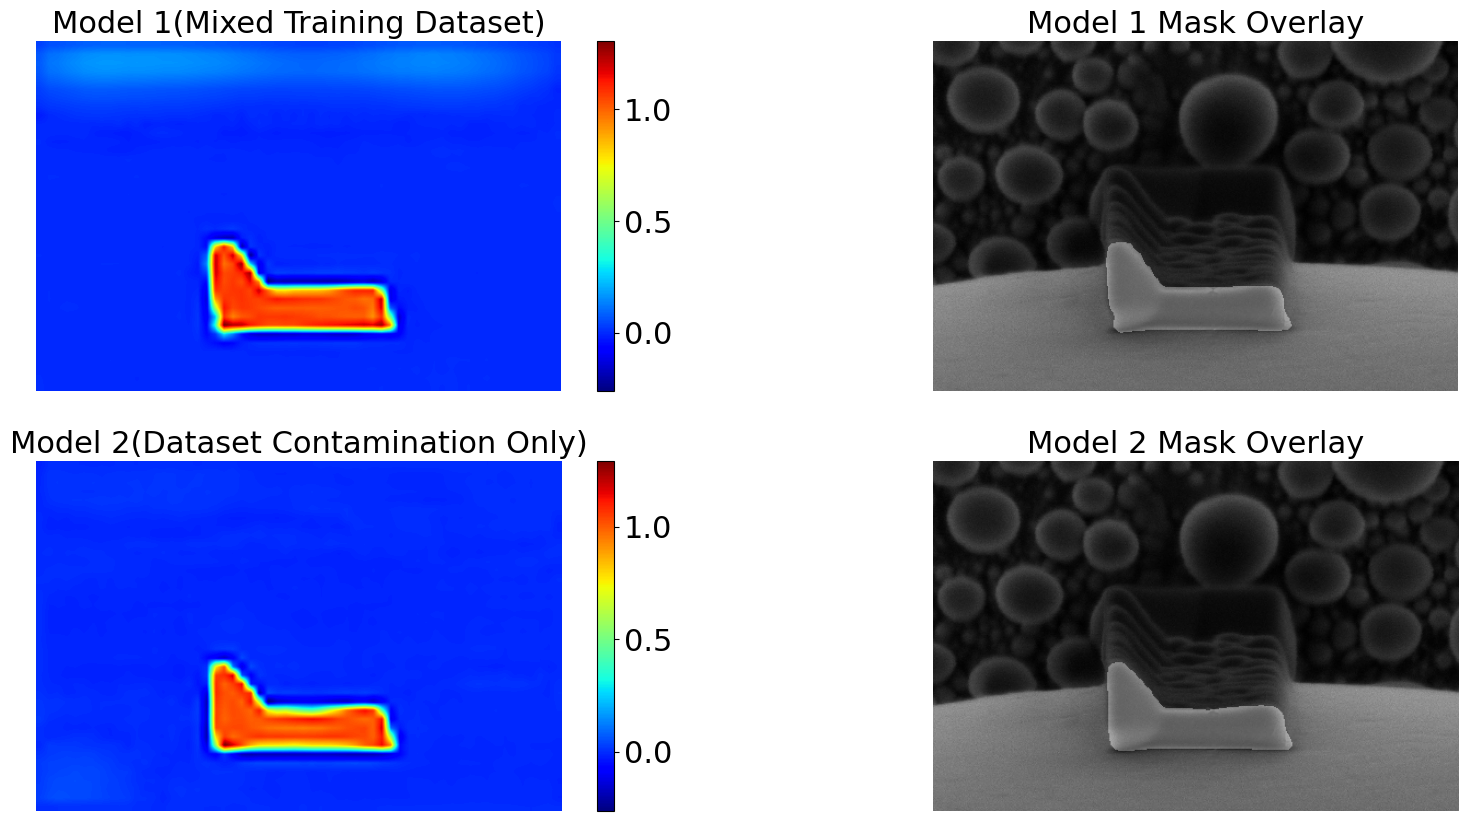

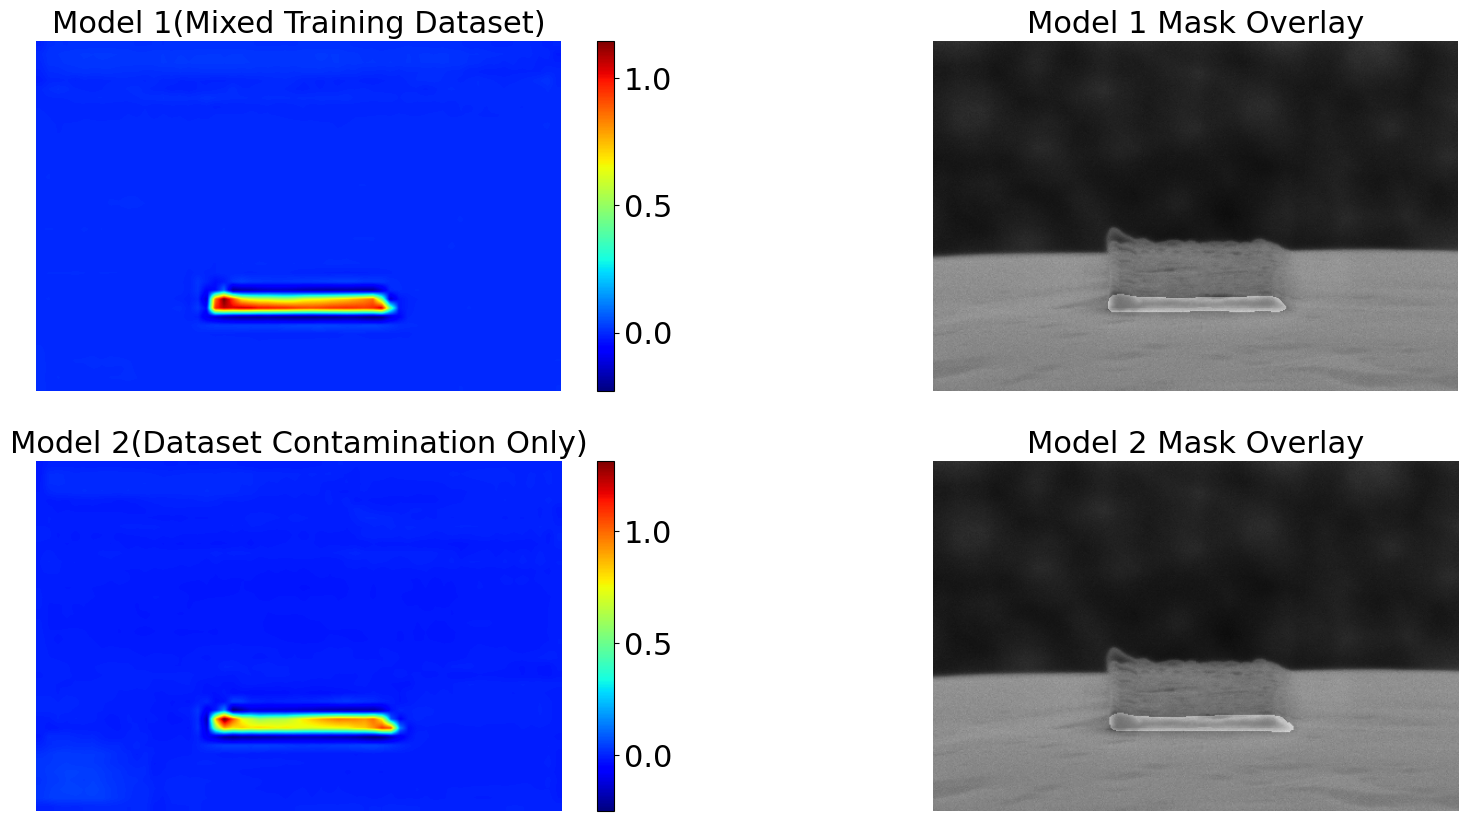

In [16]:


# Load the first trained model and set it to evaluation mode
model_1 = torch.load('./TrainingResults/weightsWithNoContaminationTraining.pt')
model_1.eval()

# Load the second trained model and set it to evaluation mode
model_2 = torch.load('./TrainingResults/WeightsContaminationOnly.pt')
model_2.eval()


# Process each image in the directory
i = 2  # Limit the number of processed images if desired

for filename in os.listdir(image_dir):
    if i == 0:
        break
    i -= 1

    # Construct paths to the image
    img_path = os.path.join(image_dir, filename)

    # Read and prepare the image
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (480, 320))
    img_for_model = resized_img.transpose(2, 0, 1).reshape(1, 3, 320, 480)
    img_tensor = torch.from_numpy(img_for_model).type(torch.cuda.FloatTensor) / 255

    # Apply the first model
    with torch.no_grad():
        output_1 = model_1(img_tensor)

    # Apply the second model
    with torch.no_grad():
        output_2 = model_2(img_tensor)

    # Get the probability maps and predicted masks
    probability_map_1 = output_1['out'].cpu().detach().numpy()[0][0]
    predicted_mask_1 = (probability_map_1 > 0.44375).astype(np.uint8) * 255

    probability_map_2 = output_2['out'].cpu().detach().numpy()[0][0]
    predicted_mask_2 = (probability_map_2 > 0.41249).astype(np.uint8) * 255

    # Resize and prepare the masks
    resized_mask_1 = cv2.resize(predicted_mask_1, (resized_img.shape[1], resized_img.shape[0]))
    resized_mask_3_channels_1 = cv2.merge((resized_mask_1, resized_mask_1, resized_mask_1))
    overlay_1 = cv2.addWeighted(resized_img, 0.7, resized_mask_3_channels_1, 0.3, 0)

    resized_mask_2 = cv2.resize(predicted_mask_2, (resized_img.shape[1], resized_img.shape[0]))
    resized_mask_3_channels_2 = cv2.merge((resized_mask_2, resized_mask_2, resized_mask_2))
    overlay_2 = cv2.addWeighted(resized_img, 0.7, resized_mask_3_channels_2, 0.3, 0)

    # Plotting
    plt.figure(figsize=(20, 10))

    # Model 1 results on the top row
    plt.subplot(2, 2, 1)
    plt.imshow(probability_map_1, cmap='jet')
    plt.colorbar()
    plt.title('Model 1(Mixed Training Dataset)', fontsize=22)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(overlay_1[..., ::-1])  # Convert BGR to RGB
    plt.title('Model 1 Mask Overlay', fontsize=22)
    plt.axis('off')

    # Model 2 results on the bottom row
    plt.subplot(2, 2, 3)
    plt.imshow(probability_map_2, cmap='jet')
    plt.colorbar()
    plt.title('Model 2(Dataset Contamination Only)', fontsize=22)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(overlay_2[..., ::-1])  # Convert BGR to RGB
    plt.title('Model 2 Mask Overlay', fontsize=22)
    plt.axis('off')
    plt.show()


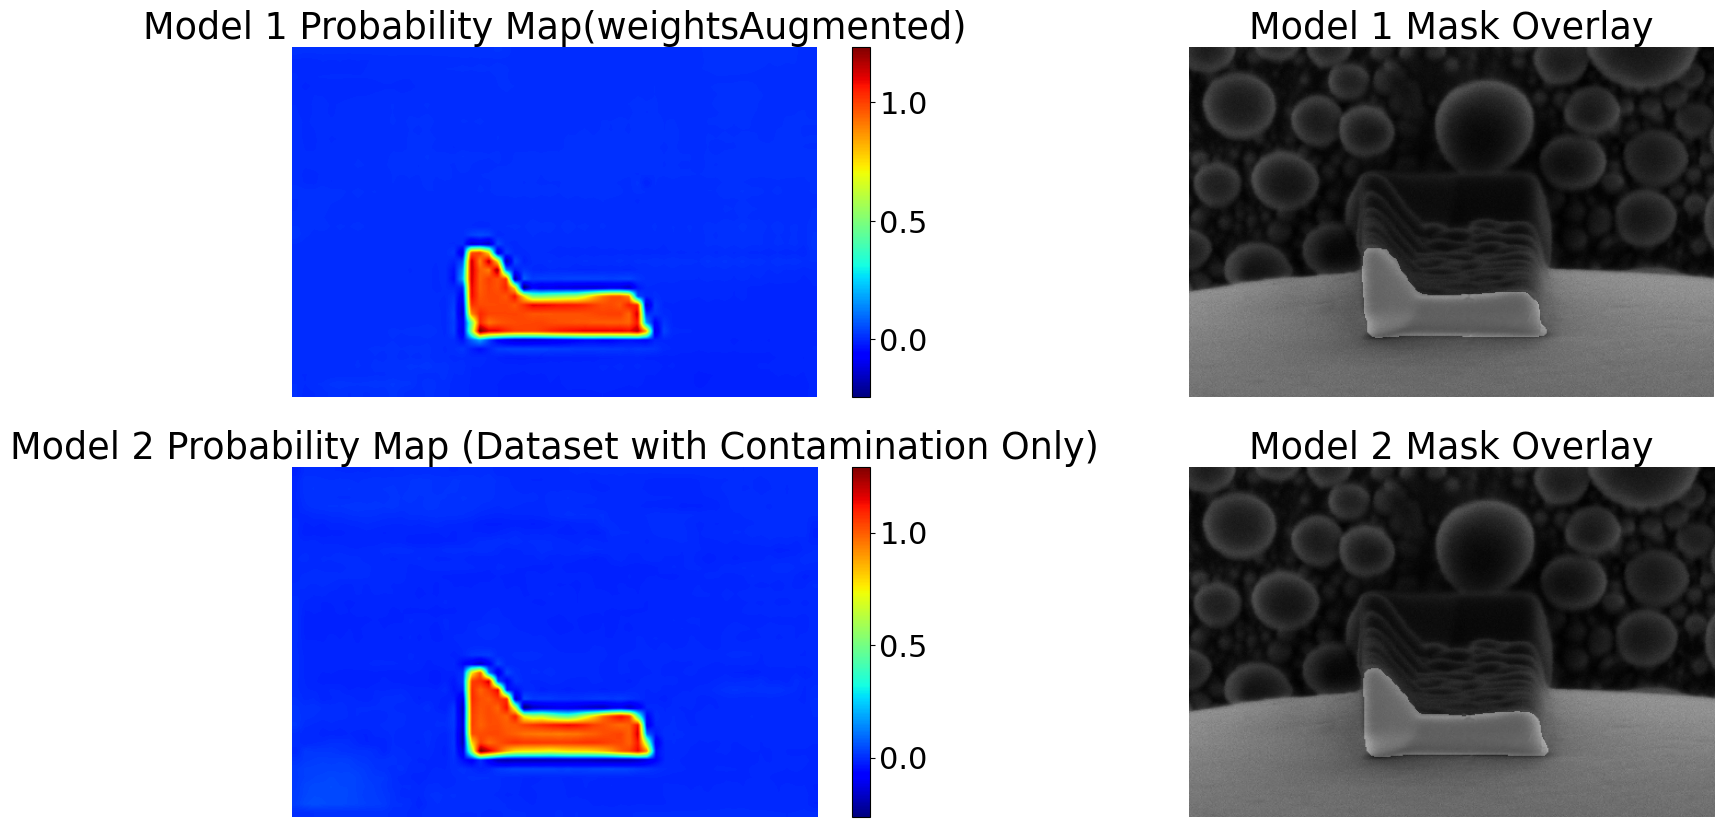

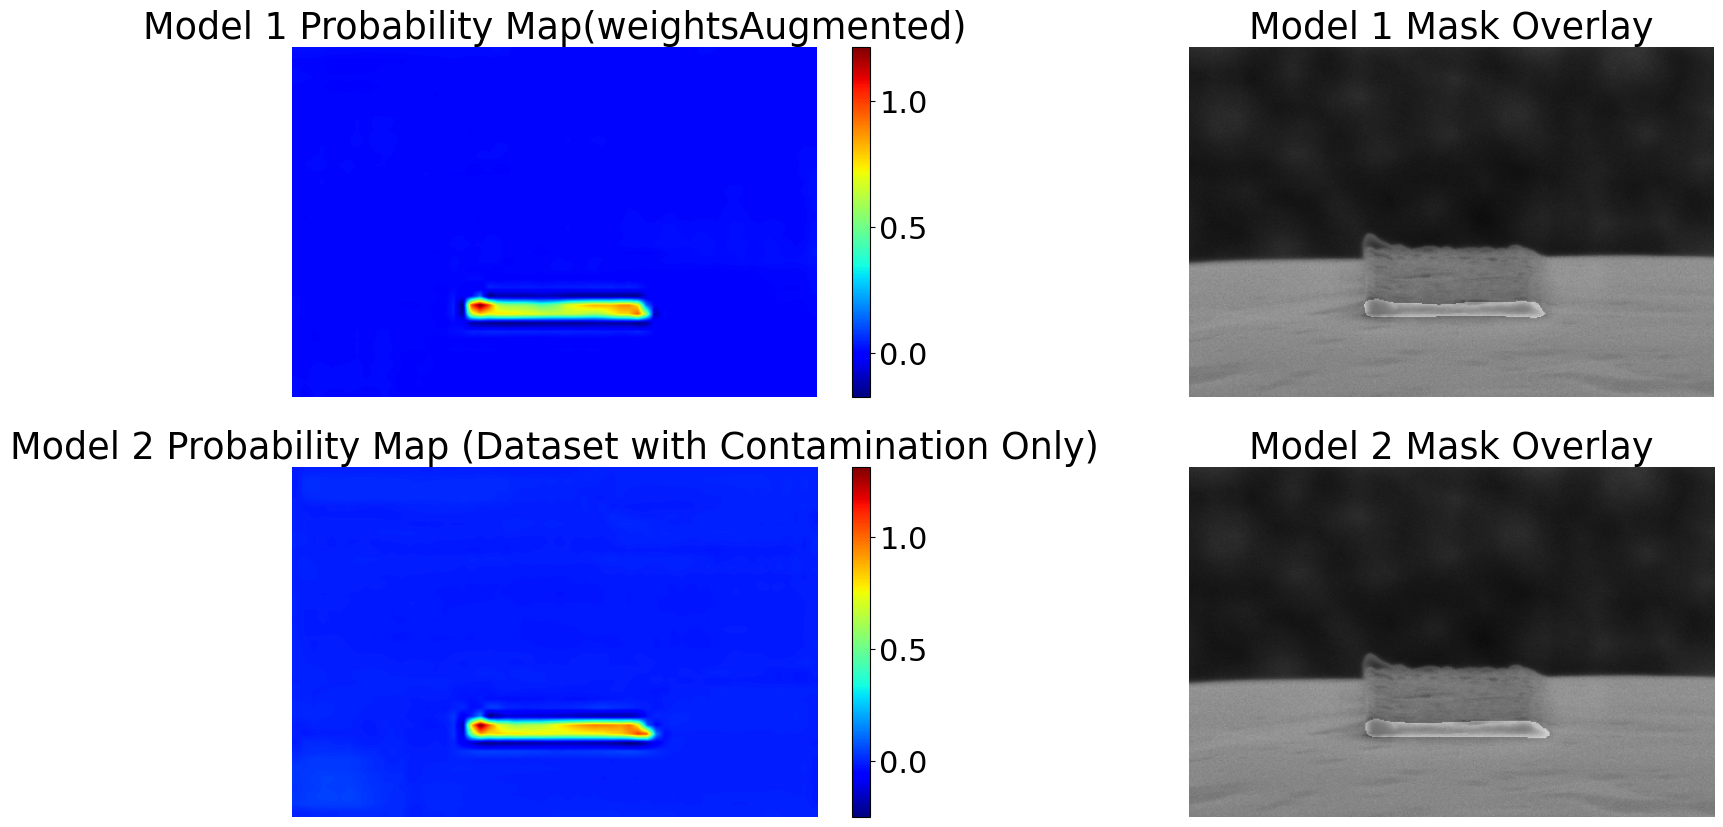

In [17]:
# Load the first trained model and set it to evaluation mode
model_1 = torch.load('./TrainingResults/weightsAugmented.pt')
model_1.eval()

# Load the second trained model and set it to evaluation mode
model_2 = torch.load('./TrainingResults/WeightsContaminationOnly.pt')
model_2.eval()

# Process each image in the directory
i = 2  # Limit the number of processed images if desired

for filename in os.listdir(image_dir):
    if i == 0:
        break
    i -= 1

    # Construct paths to the image
    img_path = os.path.join(image_dir, filename)

    # Read and prepare the image
    img = cv2.imread(img_path)
    resized_img = cv2.resize(img, (480, 320))
    img_for_model = resized_img.transpose(2, 0, 1).reshape(1, 3, 320, 480)
    img_tensor = torch.from_numpy(img_for_model).type(torch.cuda.FloatTensor) / 255

    # Apply the first model
    with torch.no_grad():
        output_1 = model_1(img_tensor)

    # Apply the second model
    with torch.no_grad():
        output_2 = model_2(img_tensor)

    # Get the probability maps and predicted masks
    probability_map_1 = output_1['out'].cpu().detach().numpy()[0][0]
    predicted_mask_1 = (probability_map_1 > 0.42187).astype(np.uint8) * 255

    probability_map_2 = output_2['out'].cpu().detach().numpy()[0][0]
    predicted_mask_2 = (probability_map_2 > 0.41249).astype(np.uint8) * 255

    # Resize and prepare the masks
    resized_mask_1 = cv2.resize(predicted_mask_1, (resized_img.shape[1], resized_img.shape[0]))
    resized_mask_3_channels_1 = cv2.merge((resized_mask_1, resized_mask_1, resized_mask_1))
    overlay_1 = cv2.addWeighted(resized_img, 0.7, resized_mask_3_channels_1, 0.3, 0)

    resized_mask_2 = cv2.resize(predicted_mask_2, (resized_img.shape[1], resized_img.shape[0]))
    resized_mask_3_channels_2 = cv2.merge((resized_mask_2, resized_mask_2, resized_mask_2))
    overlay_2 = cv2.addWeighted(resized_img, 0.7, resized_mask_3_channels_2, 0.3, 0)

    # Plotting
    plt.figure(figsize=(20, 10))

    # Model 1 results on the top row
    plt.subplot(2, 2, 1)
    plt.imshow(probability_map_1, cmap='jet')
    plt.colorbar()
    plt.title('Model 1 Probability Map(weightsAugmented)')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(overlay_1[..., ::-1])  # Convert BGR to RGB
    plt.title('Model 1 Mask Overlay')
    plt.axis('off')

    # Model 2 results on the bottom row
    plt.subplot(2, 2, 3)
    plt.imshow(probability_map_2, cmap='jet')
    plt.colorbar()
    plt.title('Model 2 Probability Map (Dataset with Contamination Only)')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(overlay_2[..., ::-1])  # Convert BGR to RGB
    plt.title('Model 2 Mask Overlay')
    plt.axis('off')

    plt.show()
